# Part 1: Introduction


For this analysis, I will consider the 2016 airline delay data only, and my goal will be to predict delays
using this one year of data. I have several hypotheses which I will evaluate throughout this presentation.

**Goal:** *Given all of the airline data from 2016, can we predict delays?*

I hypothesize that the following will provide gains in performance on predicting the departure delay:

1. The 2016 weather data obtained from https://www.ncdc.noaa.gov/.
2. Data regarding the age and model of the plane obtained from http://stat-computing.org/dataexpo/2009/plane-data.csv
3. The total capacity of the airport from which the airlplane is originating form https://en.m.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States.
4. Time series component to capture trends.
6. USA Holidays.


In [3]:
# Prelimary libraries
import pandas as pd
import pylab as plt
import seaborn
import json
import numpy as np
pd.set_option('display.max_columns', 500)
%matplotlib inline

### Table of Contents
#### Part I: Introduction.

#### Part II: Data Processing.

# Part 2: Data Processing

In this section I will outline the various processing steps which are necessary to end up with the final dataset
which will be used. For those interested only in the analysis of the predictions, you may skip to the section ** Modeling Delays**.

### Step 1: Aggregating all of the 2016 data into one file. 

Although this requires aggregating quite large data sets, I've found Python to be pretty reliable at handling up to about 5GB of data at a time. 

In [11]:
df_final=pd.DataFrame(columns=['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum', 'FlightNum',
       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID',
       'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips',
       'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID',
       'DestCityMarketID', 'Dest', 'DestCityName', 'DestState',
       'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime',
       'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff',
       'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'FirstDepTime',
       'TotalAddGTime', 'LongestAddGTime', 'DivAirportLandings',
       'DivReachedDest', 'DivActualElapsedTime', 'DivArrDelay',
       'DivDistance', 'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID',
       'Div1WheelsOn', 'Div1TotalGTime', 'Div1LongestGTime',
       'Div1WheelsOff', 'Div1TailNum', 'Div2Airport', 'Div2AirportID',
       'Div2AirportSeqID', 'Div2WheelsOn', 'Div2TotalGTime',
       'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum', 'Div3Airport',
       'Div3AirportID', 'Div3AirportSeqID', 'Div3WheelsOn',
       'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff',
       'Div3TailNum', 'Div4Airport', 'Div4AirportID', 'Div4AirportSeqID',
       'Div4WheelsOn', 'Div4TotalGTime', 'Div4LongestGTime',
       'Div4WheelsOff', 'Div4TailNum', 'Div5Airport', 'Div5AirportID',
       'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime',
       'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum', 'Unnamed: 109'])

In [16]:
df_final
for m in range(1,13):
    fname = '../data/On_Time_Performance/On_Time_On_Time_Performance_2016_' + str(m) + '.csv'
    df = pd.read_csv(fname)
    df_final=df_final.append(df)

/Users/dgoldma1/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (48,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (48,77,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity

### Step 2: Remove bad columns and causaul columns.

The following columns, upon inspection of the definitions, are the only variables (excluding DepDelay) which
won't have a causal impact on DepDelay, and which aren't mostly null (Div variables are almost all null).

In [30]:
good_cols=['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum', 'FlightNum',
       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID',
       'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips',
       'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID',
       'DestCityMarketID', 'Dest', 'DestCityName', 'DestState',
       'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime',
       'DepTime','CRSArrTime','Distance', 'DepDelay']

In [33]:
df_final=df_final[good_cols]
df_final.to_csv('../data/On_Time_Performance/On_Time_Performance_2016_agg.tsv',sep='\t',index=False)

### Step 3: Variable checking

In [4]:
df_final = pd.read_csv('../data/On_Time_Performance/On_Time_Performance_2016_agg.tsv',sep='\t')

### a) Check for null values

Since there are zero and negative values, this means any null values mean there just is missing data. So we remove these rows

In [19]:
len(df_final[df_final['DepDelay'].isnull()])/len(df_final)

0.011295810460515752

In [56]:
df_final=df_final[~df_final['DepDelay'].isnull()]

### b) Convert time values to datetime objects.

The form of the datetime is just as a string, so we need to convert this to a proper datetime object.

In [17]:
import datetime
def fix_time(row):
    x = row['CRSDepTime']
    time_str = str(int(x)).zfill(4)
    time_str_hour = int(time_str[0:2])
    if time_str_hour == 24:
        return 0
    time_str_minute = int(time_str[2:])
    
    month = int(row['Month'])
    day = int(row['DayofMonth'])

    return datetime.datetime(2016,month,day,time_str_hour,time_str_minute)
df_small['CRSDepTime']=df_small[['CRSDepTime','Month','DayofMonth']].apply(lambda row : fix_time(row),axis=1)

In [18]:
df_final['CRSDepTime'] = df_final[['CRSDepTime','Month','DayofMonth']].apply(lambda row : fix_time(row),axis=1)

In [60]:
df_final=df_final.drop(['DepTime'],1)

### b) Variable Counts

Here we check basic stats on the variables to see if anything appears odd, and to understand the distribuitons of the data. 

In [75]:
df_origins = df_final.groupby('Origin').size()
df_airlines = df_final.groupby('AirlineID').size()
df_tailnum = df_final.groupby('TailNum').size()
df_carrier = df_final.groupby('Carrier').size()

In [80]:
df_carrier

Carrier
AA     904240
AS     176520
B6     278748
DL     918730
EV     479542
F9      93980
HA      76686
NK     135674
OO     597949
UA     539849
VX      68477
WN    1283807
dtype: int64

Here we notice that there are only 12 carriers in the entire data set. This is a bit odd and indicates that
this data is somewhat incomplete. However for the purpose of this analysis, this should suffice. Analysis of the other variables appear normal.

In [484]:
df_origins.head()

Origin
ABE     2020
ABI      161
ABQ    12286
ABY     1004
ACK      287
dtype: int64

In [486]:
df_tailnum.head()

TailNum
N102UW     392
N103US     453
N104UA      24
N104UW     436
N10575    1079
dtype: int64

In [82]:
df_final.to_csv('../data/On_Time_Performance/final_cols_fixed.tsv',sep='\t',index=False)

# Exploratory analysis on variables

In this section we perform some exploratory data analysis on the variables in question. to understand their distribution
This will be very important in deciding which models are most appropriate.

### a) Departure Delays

In [93]:
df_final['DepDelay'].describe()

count    5.554202e+06
mean     8.938011e+00
std      3.976306e+01
min     -2.040000e+02
25%     -5.000000e+00
50%     -2.000000e+00
75%      6.000000e+00
max      2.149000e+03
Name: DepDelay, dtype: float64

We first observe that there are many departure delays which are negative, meaning the flights left earlier than expected.

In [96]:
len(df_final[df_final['DepDelay']<0])

3324094

In [97]:
len(df_final)

5554202

In [487]:
3324094.0/5554202

0.5984827343333929

We see that 60% of the values are actualy negative, which is a huge amount. The most natural thing to do in this setting is
to make all of these values zero. Let's first see what the positive part of the distribution looks like.

** Positive part of distribution: **

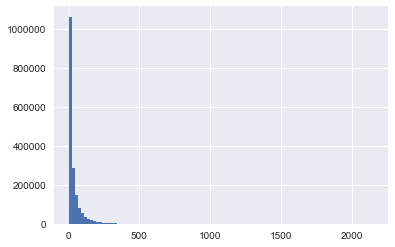

In [187]:
df_final[df_final['DepDelay']>0]['DepDelay'].hist(bins=100)

** Distribution transformed to be positive: **

In [ ]:
df_final['DepDelay_pos'] = df_final['DepDelay'].apply(lambda x : max(0,x))

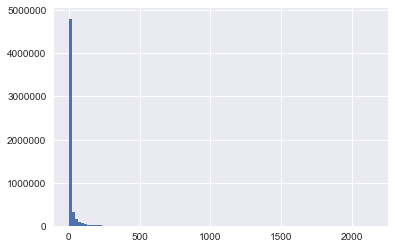

In [232]:
df_final['DepDelay_pos'].hist(bins=100)

**Note:** This appears to resemble a *fractional poisson distribution* with its concentration near 
    zero and heavy tail near $+\infty$.

** Analysis of log: **

In [101]:
df_final['DepDelay_log']=df_final['DepDelay'].apply(lambda x : np.log(max(x,1)))

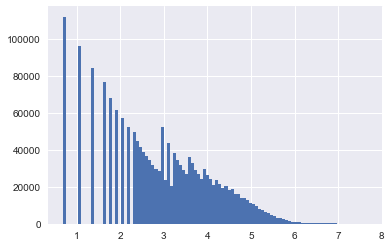

In [104]:
df_final[df_final['DepDelay']>1]['DepDelay_log'].hist(bins=100)

We see from this that the total distribution seems to be a Poisson distribution with a concentration near zero (known as a Tweedie distirbtion).
This implies that the delays for a given flight on a given day may follow this kind of distribution, and thus
we should modify our priors when performing maximum likelhihood.

### b) Other variables and their relation to Departure Delays

### Temporal information

#### Rolling mean

Here we begin looking at the time series for departure delays. The goal is to understand if there is any stationary behavior
and what the distribution over a given day. The actual time series is quite noisy, so I look at a rolling mean with a window of a month.

In [269]:
series=df_final.groupby('CRSDepTime')['DepDelay'].mean()

b.1) Zoomed in data.

CRSDepTime
2016-01-01 00:10:00   NaN
2016-01-01 00:15:00   NaN
2016-01-01 00:20:00   NaN
2016-01-01 00:24:00   NaN
2016-01-01 00:30:00   NaN
2016-01-01 00:35:00   NaN
2016-01-01 00:39:00   NaN
2016-01-01 00:40:00   NaN
2016-01-01 00:45:00   NaN
2016-01-01 00:46:00   NaN
Name: DepDelay, dtype: float64


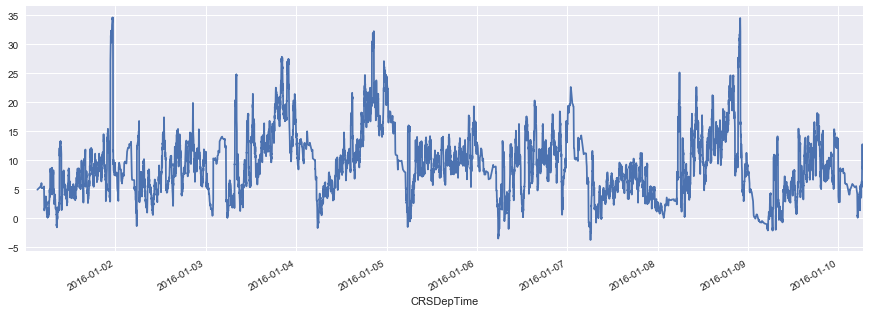

In [350]:
# Tail-rolling average transform
plt.figure(figsize=(15,5))
rolling = series.rolling(window=30)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
rolling_mean[0:10000].plot()
# plot original and transformed dataset

The time separation is a bit noisy (no equal separation of time scales) and not equally distributed. Rather than fixing this here though, we will
do so in the time series section. 

b.2) Entire dataset.

CRSDepTime
2016-01-01 00:10:00   NaN
2016-01-01 00:15:00   NaN
2016-01-01 00:20:00   NaN
2016-01-01 00:24:00   NaN
2016-01-01 00:30:00   NaN
2016-01-01 00:35:00   NaN
2016-01-01 00:39:00   NaN
2016-01-01 00:40:00   NaN
2016-01-01 00:45:00   NaN
2016-01-01 00:46:00   NaN
Name: DepDelay, dtype: float64


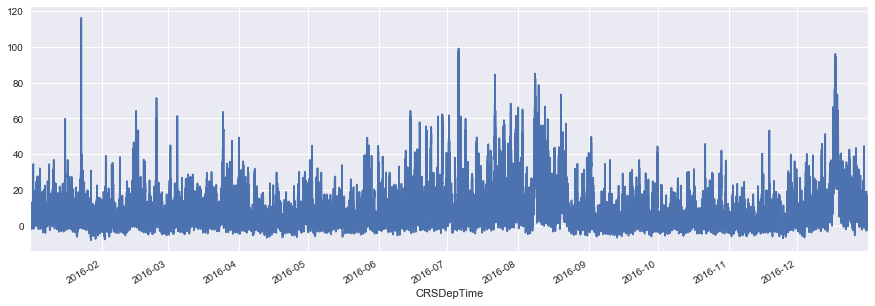

In [359]:
# Tail-rolling average transform
plt.figure(figsize=(15,5))
rolling = series.rolling(window=30)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
rolling_mean.plot()
# plot original and transformed dataset

### Conclusion: 

The time series data appears to have a spike in the summer seasons and around the winter holidays. An auto correlation will be done in the time series section and maximum likelhihood estimates with different prior distributions will be attempted. The data here seems to suggest there is some autocorrelation of the departure delays, and that the distribution has a Gamma or Poisson like distribution.
This suggests there is some seasonal behavior and also that weather could play a factor. 


For now, we will aggregate on a daily, monthly and hourly level to see what trends occur.

### Daily

We start by taking a sample of the data to see if the trend observed in the summer and winter holds true.

FlightDate
2016-01-01     6.784034
2016-01-02     9.111778
2016-01-03    12.323874
2016-01-04    11.228356
2016-01-05    12.498644
2016-01-06    10.402533
2016-01-07     6.121184
2016-01-08     9.660244
2016-01-09     6.844305
2016-01-10    17.208583
Name: DepDelay, dtype: float64


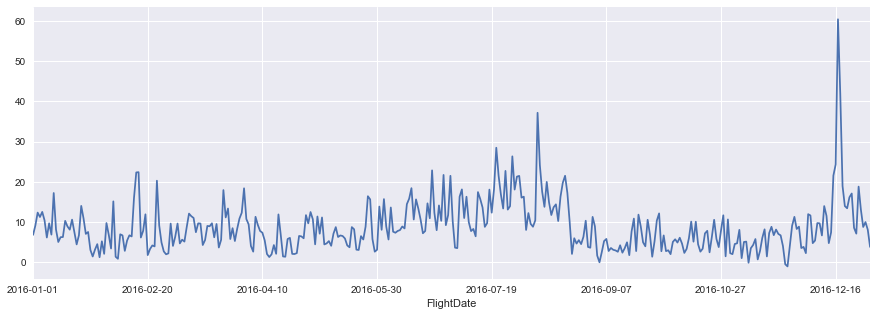

In [362]:
# Tail-rolling average transform
series=df_final.groupby('FlightDate')['DepDelay'].mean()
plt.figure(figsize=(15,5))
#rolling = series.rolling(window=30)
rolling_mean = series #rolling.mean()
print(rolling_mean.head(10))
rolling_mean[0:10000].plot()

The above implies that there is a seaonal trend in the summer and in the winter, implying that traffic
is a very important factor in the delays. 

### Distribution of data on a given day.

We now see that there is most likely some seasonal trend. We would like to now understand what the distributions
on a given day look like - this will motivate the model we use. Let's compare some of the peak days we observed
in the last section.

(0, 200)

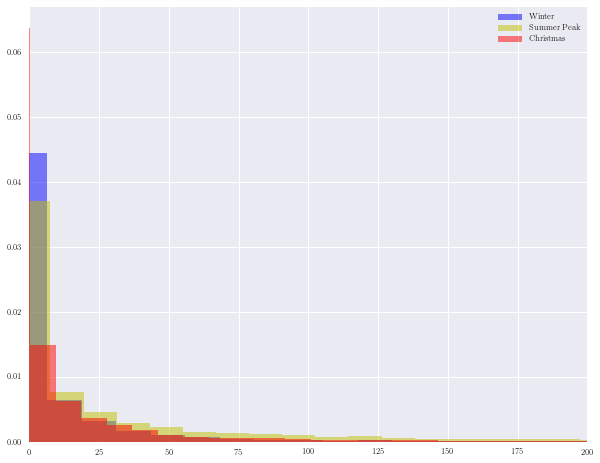

In [595]:
plt.figure(figsize=(10,8))
df_final[df_final['FlightDate']=='2016-01-20']['DepDelay'].hist(bins=120,alpha=0.5,color='b',label='Winter',normed=True)
df_final[df_final['FlightDate']=='2016-08-20']['DepDelay'].hist(bins=120,alpha=0.5,label='Summer Peak',color='y',normed=True)
df_final[df_final['FlightDate']=='2016-12-25']['DepDelay'].hist(bins=120,alpha=0.5,label='Christmas',color='r',normed=True)
plt.legend()
plt.xlim([0,200])

This shows that the distribution of delays for any given day seem to have a Gamma distribution or a fractional
poisson distribution. Indeed consider the example below.

### Fitting to different distributions.

Here we do some qualitative/adhoc comparison of fitting the delays over a given day to different distributions. We try
1. Poisson.
2. Gamma
3. Beta
4. Normal

### Before setting negative values to 0

Let's see which distributio fits best when we don't push the negative delays to zero.

/Users/dgoldma1/anaconda/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


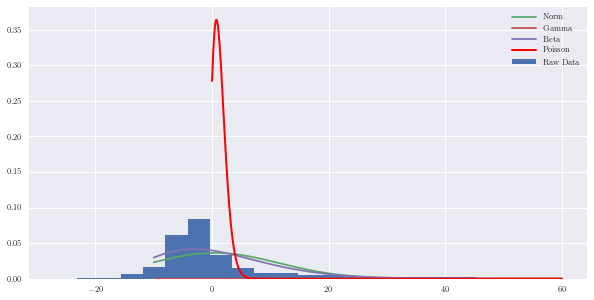

In [615]:
# Poisson piece needs to be custom
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import factorial

# plot normed histogram
christmas=df_final[(df_final['FlightDate']=='2016-12-25') & ~(df_final['DepDelay'].isnull())]['DepDelay'].dropna().values
#christmas = np.array[max(c,0) for c in list(christmas)])
ser=christmas[(christmas <50)]
plt.figure(figsize=(10,5))
plt.hist(ser,normed=True,bins=20,label='Raw Data')

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax =-10, 60 
lnspc = np.linspace(xmin, xmax, len(ser))

# lets try the normal distribution first
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

# exactly same as above
ag,bg,cg = stats.gamma.fit(ser)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

# guess what :) 
ab,bb,cb,db = stats.beta.fit(ser)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label="Beta")



# get poisson deviated random numbers
data = christmas[christmas>0]

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 60, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Poisson')
plt.legend()


plt.show()

As we see here, the Beta distribution appears to be the best, but is still not very good. Poisson is completely off, since it has
zero support for negative values.

### After settign negative values to zero

Let's see how things look when we collapse all negatie values to zero.

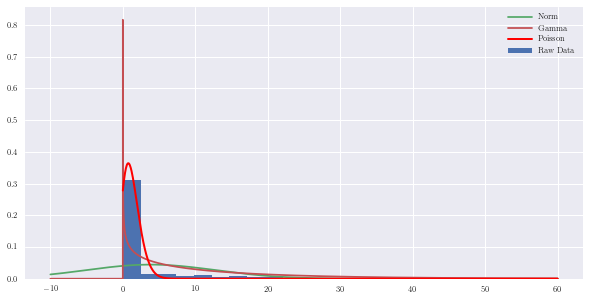

In [618]:
# plot normed histogram
christmas=df_final[(df_final['FlightDate']=='2016-12-25') & ~(df_final['DepDelay'].isnull())]['DepDelay'].dropna().values
christmas = np.array([max(c,0) for c in list(christmas)])
ser=christmas[(christmas <50)]
plt.figure(figsize=(10,5))
plt.hist(ser,normed=True,bins=20,label='Raw Data')

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax =-10, 60 
lnspc = np.linspace(xmin, xmax, len(ser))

# lets try the normal distribution first
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

# exactly same as above
ag,bg,cg = stats.gamma.fit(ser)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

# guess what :) 
#ab,bb,cb,db = stats.beta.fit(ser)  
##pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
#plt.plot(lnspc, pdf_beta, label="Beta")

# Poisson piece needs to be custom
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import factorial


# get poisson deviated random numbers
data = christmas[christmas>0]

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 60, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Poisson')
plt.legend()


plt.show()

Here it appears that Poisson looks the most appropriate, which confirms our previous guess when looking at the entire distribution.

Let's plot the comparison for Christmas day, which should have more delays than usual.'

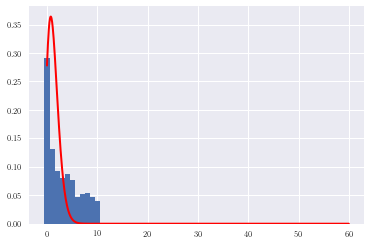

In [609]:


# get poisson deviated random numbers
data = christmas

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 60, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.show()

This appears to be a very good fit. we expect that for larger delays,  Poisson will work better.

In [491]:
def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes",figsize=(10,5))

### Analysis of more temporal variables.

### Month

In [139]:
df_more_delays_2=df_final[df_final['DepDelay_log']>3]

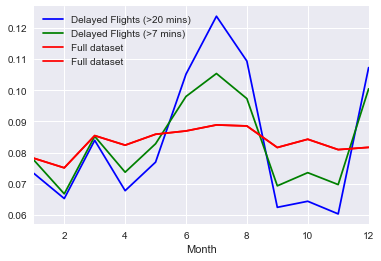

In [136]:
(df_more_delays.groupby('Month').size()/df_more_delays.groupby('Month').size().sum()).plot(color='b',label='Delayed Flights (>20 mins)')
(df_more_delays_2.groupby('Month').size()/df_more_delays_2.groupby('Month').size().sum()).plot(color='g',label='Delayed Flights (>7 mins)')
(df_final.groupby('Month').size()/df_final.groupby('Month').size().sum()).plot(color='r',label='Full dataset')
(df_final.groupby('Month').size()/df_final.groupby('Month').size().sum()).plot(color='r',label='Full dataset')
plt.legend()

### Hour

We will see below that delays are worst later in the evening, when more people are flying. This suggests
making hour a separate variable, which we will do in our model.

In [248]:
def get_hour(x):
    hour = str(x).split(' ')[1].split(':')[0]
    return hour
df_small['hour']=df_small['CRSDepTime'].apply(lambda x : get_hour(x))

In [249]:
df_final['hour']=df_final['CRSDepTime'].apply(lambda x : get_hour(x))

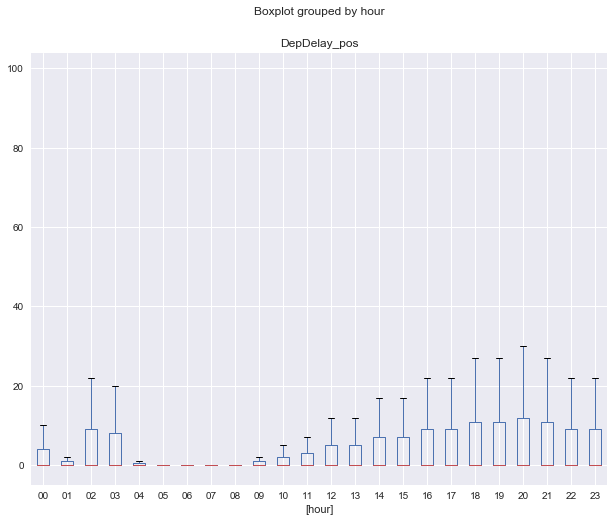

In [388]:
plt.figure(figsize=(20,10))
df_final[(df_final['DepDelay']<100) ][['hour','DepDelay_pos']].boxplot( by='hour',figsize=(10,8))

### Day of Month

There appears to be a small peak around the middle of the month, but very small. 

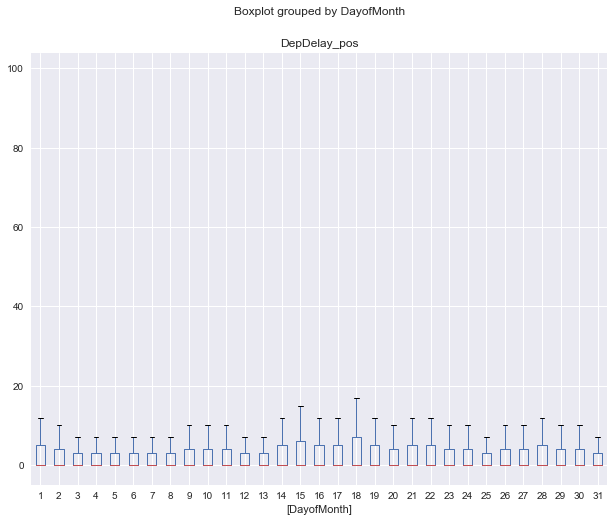

In [389]:
plt.figure(figsize=(20,10))
df_final[df_final['DepDelay']<100][['DayofMonth','DepDelay_pos']].boxplot( by='DayofMonth',figsize=(10,8))

We will see below that the introduction of this variable improves the R^2 from 0.017 to 0.02.

### Quarter 

Consistent in our observations fro above, we see the largest delay in the third quarter, which is in the summer.

In [287]:
df_final.groupby('Quarter')['DepDelay'].mean()

Quarter
1     7.893277
2     8.496406
3    11.239215
4     7.990617
Name: DepDelay, dtype: float64

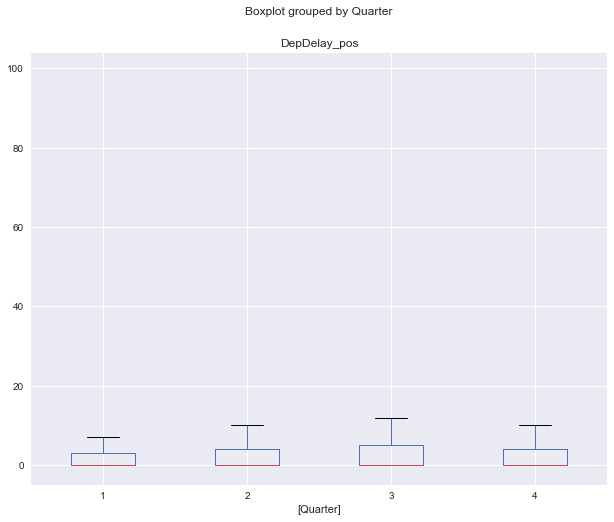

In [394]:
plt.figure(figsize=(20,10))
df_final[df_final['DepDelay']<100][['Quarter','DepDelay_pos']].boxplot( by='Quarter',figsize=(10,8))

Here we look only at positive delays.

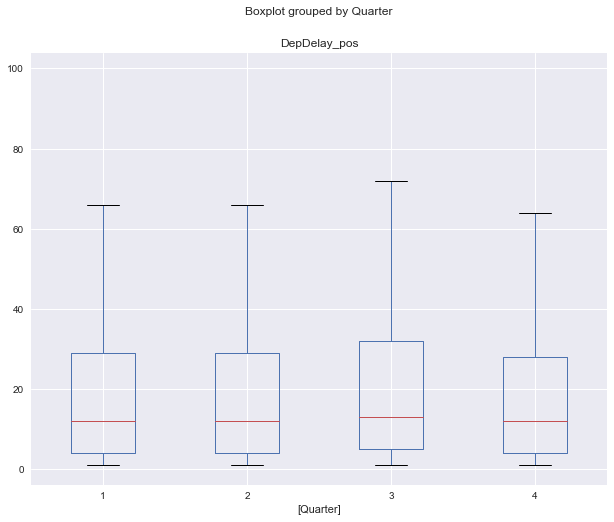

In [399]:
plt.figure(figsize=(20,10))
df_final[(df_final['DepDelay']<100) & (df_final['DepDelay']>0)][['Quarter','DepDelay_pos']].boxplot( by='Quarter',figsize=(10,8))

### Carrier information

Certain carriers seem to be worse than others. Frontier, Spirit and EVA Air Corporation. These airlines
having the worst delays are consistent with my experience, so this is a good sanity check.

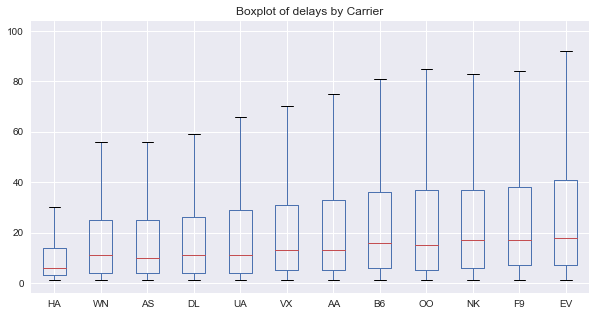

In [413]:
  
axes = boxplot_sorted(df_final[(df_final['DepDelay']<100) & (df_final['DepDelay']>0) ], by=["Carrier"], column="DepDelay_pos")
axes.set_title("Boxplot of delays by Carrier")


B6: Jet Blue

F9: Frontier Airlines

NK: Spirit Airlines

UA: United Airlines

EV: EVA Air Corporation

### Airport information

In [437]:
df_airports = df_final.groupby('Origin')['DepDelay'].mean().sort_values()
df_airports_sizes = df_final.groupby('Origin')['DepDelay'].size().sort_values()

In [440]:
popular_airports=df_airports_sizes[5:]

In [453]:
df_final=df_final[df_final['Origin'].isin(popular_airports.index)]

In [454]:
df_airports = df_final.groupby('Origin')['DepDelay'].mean().sort_values()
df_airports_sizes = df_final.groupby('Origin')['DepDelay'].size().sort_values()

In [460]:
df_airports[-10:]

Origin
GUC    15.420168
MQT    15.874269
CMX    16.507205
SAF    16.741990
BPT    17.260788
OTH    20.192440
MVY    20.822581
GCK    20.833333
MMH    22.560440
PPG    52.553719
Name: DepDelay, dtype: float64

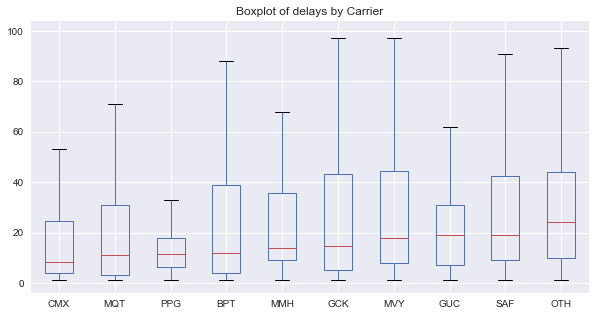

In [461]:
axes = boxplot_sorted(df_final[(df_final['DepDelay']<100) & (df_final['DepDelay']>0) & (df_final['Origin'].isin(df_airports[-10:].index))], by=["Origin"], column="DepDelay_pos")
axes.set_title("Boxplot of delays by Carrier")

In [ ]:
# Southwest Oregon Regional Airport
# San Francisco
#Gunnison–Crested Butte Regional Airport

### Holidays

As an additional variable to add in, motivated by some of the above observations, we see which
holidays relate the most to departure delays. 

In [ ]:
df_holidays = pd.read_csv('../data/holidays/holidays_07-17.csv').drop(['Unnamed: 0'],1)

In [9]:
df_holidays.head()

,Date,Weekday,Holiday.Name,Holiday.Type
0,2017-01-01,Sunday,Last Day of Chanukah,Jewish holiday
1,2017-01-01,Sunday,New Year's Day,Federal Holiday
2,2017-01-02,Monday,New Year's Day observed,Federal Holiday
3,2017-01-16,Monday,Martin Luther King Jr. Day,Federal Holiday
4,2017-02-20,Monday,Presidents' Day,Federal Holiday


In [10]:
df_holidays['FlightDate']=df_holidays['Date']
df_final_holiday=pd.merge(df_final,df_holidays,how='left',on='FlightDate')

We create a categorical variable to determine if it's a holiday or not. 

In [11]:
df_final_holiday['is_holiday']=~df_final_holiday['Holiday.Name'].isnull()

In [347]:
df_final_holiday.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,CRSArrTime,Distance,DepDelay,DepDelay_log,DepDelay_class,DepDelay_pos,hour,Date,Weekday,Holiday.Name,Holiday.Type,is_holiday
0,2016,1,1,6,3,2016-01-06,AA,19805,AA,N4YBAA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,2016-01-06 11:00:00,1438,986.0,-3.0,0.000000,0,0.0,11,NaN,NaN,NaN,NaN,False
1,2016,1,1,7,4,2016-01-07,AA,19805,AA,N434AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,2016-01-07 11:00:00,1438,986.0,-4.0,0.000000,0,0.0,11,NaN,NaN,NaN,NaN,False
2,2016,1,1,8,5,2016-01-08,AA,19805,AA,N541AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,2016-01-08 11:00:00,1438,986.0,-5.0,0.000000,0,0.0,11,NaN,NaN,NaN,NaN,False
3,2016,1,1,9,6,2016-01-09,AA,19805,AA,N489AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,2016-01-09 11:00:00,1438,986.0,2.0,0.693147,0,2.0,11,NaN,NaN,NaN,NaN,False
4,2016,1,1,10,7,2016-01-10,AA,19805,AA,N439AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26,Michigan,43,2016-01-10 11:00:00,1438,986.0,100.0,4.605170,1,100.0,11,NaN,NaN,NaN,NaN,False


Let's see if holidays are more correlated with delays. It turns out there are overall less delays on holidays.

In [13]:
df_final_holiday.groupby('is_holiday')['DepDelay'].mean()

is_holiday
False    9.086116
True     7.099671
Name: DepDelay, dtype: float64

** Delays by particular holiday: **

We see here that Chritmas day and President's day are the worst. Given that the mean delay is 8.9 minutes
as observed above, we see that most holidays have less delay. Thanksgiving day has a very low delay, most likely
since everyone stays local or within driving distance for this particular holiday.

In [310]:
df_final_holiday.groupby('Holiday.Name')['DepDelay'].mean()

Holiday.Name
Chanukah/Hanukkah (first day)     7.089130
Christmas Day                     7.089130
Christmas Day observed           18.797550
Christmas Eve                     8.553534
Columbus Day                      4.599096
Dussehra                          4.599096
Easter Monday                     8.446117
Easter Sunday                     5.741386
Eid al-Adha                       4.190807
Eid al-Fitr                      18.101829
Ganesh Chaturthi                 -0.047114
Good Friday                      11.126024
Holi                              5.544060
Independence Day                  3.480856
Isra and Mi'raj                   7.077166
Janmashtami                       4.618030
Labor Day                         2.478333
Lailat al-Qadr                   10.145052
Last Day of Passover              9.650568
Last Day of Sukkot                6.270130
Maha Shivaratri                   5.109192
Martin Luther King Jr. Day       10.569690
Memorial Day                      3.06723

We see that Hindu holidays actually have the lowest delays overall. State holidays appear to be the worst - suggesting that people leave town for the weekend.

In [345]:
df_final_holiday.groupby('Holiday.Type')['DepDelay'].mean()

Holiday.Type
Christian                 8.446117
Federal Holiday           7.980103
Hindu Holiday             4.926383
Jewish holiday            5.022378
Muslim                    8.749381
Observance, Christian     6.974810
State holiday            11.126024
Name: DepDelay, dtype: float64

## Conclusions

1. The time of the year and the time of day seem to have a large impact on delays. This suggests that traffic
is actually to blame. In the summer season when people are on vacation, or the fact that most people prefer to have
mid day or early evening flights suggets this. 

2. The distribution over given days appears to be well approximated by a fractional Poisson distribution, implying
that some kind of Poisson regresion time series model may be the most appropriate. 

# Part IV: Feature Engineering

# IV.1) Weather

Here we load in the weather data generated in the other notebook.

In [787]:
df_weather = pd.read_csv('../data/weather/all_weather_data_agg.tsv',sep='\t')

In [788]:
pd.merge(df_ts,df_weather,how='inner',on='locationID')

,locationID,airport_code,lat,lon,date,TMAX,TMIN,PRCP,AWND,TAVG,WDF2,WDF5,WSF2,WSF5,TOBS,SNOW,SNWD,WT01,WT08,WT03,WT02,PSUN,TSUN,PGTM,WESD,WESF,WT05,WT06,WT04,WT11,WT09,DAPR,MDPR,SN32,SX32,WT07,WT10,SN52,SX52,EVAP,MNPN,MXPN,WDMV
0,01FL,USW00012854,28.8,81.2,20160101,289,189,0,26,0,10,20,76,94,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,01FL,USW00012854,28.8,81.2,20160102,206,156,0,41,0,360,10,76,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,01FL,USW00012854,28.8,81.2,20160103,156,89,178,42,0,320,340,76,98,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01FL,USW00012854,28.8,81.2,20160104,189,78,0,45,0,310,340,72,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,01FL,USW00012854,28.8,81.2,20160105,200,111,0,54,0,70,70,107,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df_final=pd.read_csv('../data/On_Time_Performance/final_cols_fixed.tsv',sep='\t')

In [9]:
df_sample = df_final.sample(1000)

In [10]:
df_weather = pd.read_csv('../data/weather/all_weather_data_agg.tsv',sep='\t')

In [11]:
df_weather.head()


,locationID,airport_code,lat,lon,date,TMAX,TMIN,PRCP,AWND,TAVG,WDF2,WDF5,WSF2,WSF5,TOBS,SNOW,SNWD,WT01,WT08,WT03,WT02,PSUN,TSUN,PGTM,WESD,WESF,WT05,WT06,WT04,WT11,WT09,DAPR,MDPR,SN32,SX32,WT07,WT10,SN52,SX52,EVAP,MNPN,MXPN,WDMV
0,01FL,USW00012854,28.8,81.2,20160101,289,189,0,26,0,10,20,76,94,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,01FL,USW00012854,28.8,81.2,20160102,206,156,0,41,0,360,10,76,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,01FL,USW00012854,28.8,81.2,20160103,156,89,178,42,0,320,340,76,98,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01FL,USW00012854,28.8,81.2,20160104,189,78,0,45,0,310,340,72,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,01FL,USW00012854,28.8,81.2,20160105,200,111,0,54,0,70,70,107,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [276]:
import re
df_sample['date'] = df_sample['FlightDate'].apply(lambda x : int(re.sub("-","",x)))
df_sample['locationID'] = df_sample['Origin']
df_ts_w=pd.merge(df_sample,df_weather,how='inner',on=['locationID','date'])

In [68]:
weather_cols = df_weather.columns
weather_cols = list(weather_cols) + ['DepDelay']

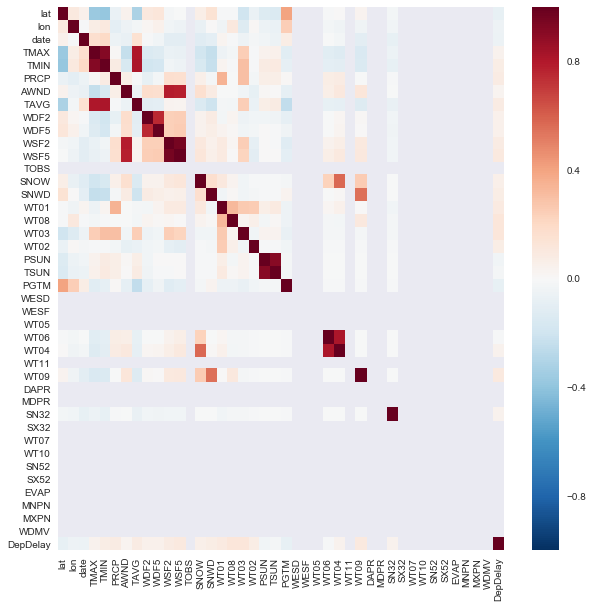

In [73]:
import seaborn as sns
plt.figure(figsize=(10,10))
corr = df_ts_w[weather_cols].corr()
sns.heatmap(corr)

It turns out that the wind speed has the highest correlation with delays, not preciptiation or snow. This most likely is due to planes not arriving at their destinations on time, and thus delaying their subsequent departure.

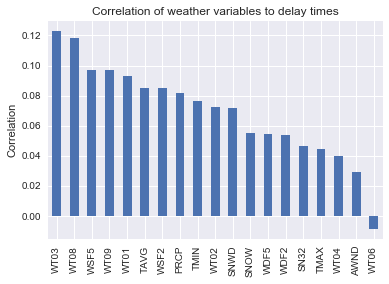

In [81]:
max_corrs = corr['DepDelay'].sort_values()
plt.ylabel('Correlation')
plt.title('Correlation of weather variables to delay times')
max_corrs[::-1].dropna()[1:20].plot(kind='bar')

# Plane data 

In [35]:
df_plane_data=pd.read_csv('../data/airport_data/plane-data.csv')

In [262]:
df_plane_data.dropna().head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,TailNum
34,N10156,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,N10156
35,N102UW,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,N102UW
36,N10323,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,N10323
37,N103US,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,N103US
38,N104UA,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,N104UA


In [40]:
df_plane_data.dtypes

tailnum          object
type             object
manufacturer     object
issue_date       object
model            object
status           object
aircraft_type    object
engine_type      object
year             object
dtype: object

In [38]:
df_plane_data = df_plane_data.dropna()

In [84]:
df_plane_data.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,TailNum
34,N10156,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004,N10156
35,N102UW,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,N102UW
36,N10323,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986,N10323
37,N103US,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999,N103US
38,N104UA,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998,N104UA


In [264]:
len(df_ts_w)

724

In [86]:
plane_cols = df_plane_data.columns.values

In [88]:
plane_cols = list(plane_cols) + ['DepDelay']

In [280]:
df_plane_data['TailNum'] =df_plane_data['tailnum']
df_ts_wp = pd.merge(df_ts_w,df_plane_data,how='inner',on='TailNum')

## Holiday Data

## Merging


In [394]:
df_plane_data['TailNum'] =df_plane_data['tailnum']
df_ts_wp = pd.merge(df_final_feat,df_plane_data,how='inner',on='TailNum')

In [286]:
df_ts_wp.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,CRSArrTime,Distance,DepDelay,locationID,date,airport_code,lat,lon,TMAX,TMIN,PRCP,AWND,TAVG,WDF2,WDF5,WSF2,WSF5,TOBS,SNOW,SNWD,WT01,WT08,WT03,WT02,PSUN,TSUN,PGTM,WESD,WESF,WT05,WT06,WT04,WT11,WT09,DAPR,MDPR,SN32,SX32,WT07,WT10,SN52,SX52,EVAP,MNPN,MXPN,WDMV,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,2016,2,6,17,5,2016-06-17,HA,19690,HA,N486HA,312,12173,1217302,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,12402,1240203,32402,ITO,"Hilo, HI",HI,15,Hawaii,2,2016-06-17 18:32:00,1925,216.0,11.0,HNL,20160617,USW00022521,21.3,157.9,289,228,8,59,254,70,80,116,143,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N486HA,Corporation,BOEING,11/21/2001,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2001
1,2016,2,4,14,4,2016-04-14,HA,19690,HA,N486HA,138,12173,1217302,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,12758,1275803,32758,KOA,"Kona, HI",HI,15,Hawaii,2,2016-04-14 12:47:00,1334,163.0,0.0,HNL,20160414,USW00022521,21.3,157.9,300,233,3,64,257,80,80,112,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N486HA,Corporation,BOEING,11/21/2001,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2001
2,2016,1,2,22,1,2016-02-22,HA,19690,HA,N486HA,171,12173,1217302,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,12982,1298202,32982,LIH,"Lihue, HI",HI,15,Hawaii,2,2016-02-22 14:10:00,1453,102.0,-4.0,HNL,20160222,USW00022521,21.3,157.9,272,183,0,38,228,340,350,81,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N486HA,Corporation,BOEING,11/21/2001,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2001
3,2016,3,7,4,1,2016-07-04,HA,19690,HA,N486HA,334,12173,1217302,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,13830,1383002,33830,OGG,"Kahului, HI",HI,15,Hawaii,2,2016-07-04 15:03:00,1543,100.0,-6.0,HNL,20160704,USW00022521,21.3,157.9,306,244,8,56,269,60,60,98,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N486HA,Corporation,BOEING,11/21/2001,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2001
4,2016,2,4,10,7,2016-04-10,HA,19690,HA,N486HA,520,12173,1217302,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,13830,1383002,33830,OGG,"Kahului, HI",HI,15,Hawaii,2,2016-04-10 09:45:00,1025,100.0,-8.0,HNL,20160410,USW00022521,21.3,157.9,300,211,0,41,254,40,20,98,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,N486HA,Corporation,BOEING,11/21/2001,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2001


In [400]:
df_ts_wp['date']=df_ts_wp['FlightDate'].apply(lambda x : re.sub("-","",x))

In [290]:
df_holidays['date'] = df_holidays['Date'].apply(lambda x : re.sub("-","",x))

In [401]:
df_ts_wph = pd.merge(df_ts_wp,df_holidays,how='left',on='date')

In [293]:
df_ts_wph.to_csv('../data/all_data_sampled.tsv',sep='\t')


# Busy airports

In [ ]:
df_busy = pd.read_csv('../data/airport_data/airport_business.tsv',sep='\t')

In [349]:
df_busy.head()

,Rank,Locid,S/L,Hub,CY 16 Enplanements,CY 15 Enplanements,% Change
0,1,ATL,P,L,"50,476,272","49,340,732",2.30%
1,2,LAX,P,L,"39,635,691","36,351,272",9.04%
2,3,ORD,P,L,"37,499,201","36,305,668",3.29%
3,4,DFW,P,L,"31,274,875","31,589,839",-1.00%
4,5,JFK,P,L,"29,224,554","27,782,369",5.19%


In [367]:
df_busy['Origin'] = df_busy['Locid']

In [370]:
cols=df_busy.columns.values
cols = list(cols) + ['DepDelay_pos']

In [377]:
df_ts_wph[cols].corr()

,Rank,CY 16 Enplanements,CY 15 Enplanements,% Change,DepDelay_pos
Rank,1.000000,-0.609457,-0.606620,-0.198179,-0.000178
CY 16 Enplanements,-0.609457,1.000000,0.999183,0.023120,0.012451
CY 15 Enplanements,-0.606620,0.999183,1.000000,-0.002103,0.011376
% Change,-0.198179,0.023120,-0.002103,1.000000,0.019708
DepDelay_pos,-0.000178,0.012451,0.011376,0.019708,1.000000


In [404]:
df_ts_wph=pd.merge(df_ts_wph,df_busy,how='inner',on='Origin')

In [8]:
df_ts_wph=pd.merge(df_ts_wph,df_weather,how='inner',on=['locationID','date'])

In [9]:
df_ts_wph.to_csv('../data/final_all.tsv',sep='\t',index=False)

In [43]:
df_balanced.to_csv('../data/balanced.tsv',sep='\t',index=False)